In [54]:
import pickle 
import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

import pandas as pd
from scipy import optimize
from tqdm import tqdm
import random

import h5py
from mygalaxy import to_img
from scipy.signal import convolve2d
from model import UNet
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
import time

In [55]:
# def to_model(x):
#     x = torch.Tensor(img_dir.reshape(1, 1, 128, 128))
#     x = x.to(device)
#     with torch.no_grad():
#         y_hat = unet(x)
#         y_hat = y_hat.detach().cpu().numpy()[0,0]
#     return y_hat

# ref: https://github.com/astronomical-data-processing/fundamentals_of_interferometry_chinese

def subtractPSF(img, psf, l, m, flux, gain):
    """Subtract the PSF (attenuated by the gain and flux) centred at (l,m) from an image"""
    
    #get the half lengths of the PSF
    if (psf.shape[0] % 2 == 0): psfMidL = psf.shape[0]/2 #even
    else: psfMidL = (psf.shape[0]+1)/2 #odd
    if (psf.shape[1] % 2 == 0): psfMidM = psf.shape[1]/2 #even
    else: psfMidM = (psf.shape[1]+1)/2 #odd
    
    #determine limits of sub-images
    #starting m
    if m-psfMidM < 0:
        subM0 = 0
        subPSFM0 = psfMidM-m
    else:
        subM0 = m-psfMidM
        subPSFM0 = 0
    #starting l
    if l-psfMidL < 0:
        subL0 = 0
        subPSFL0 = psfMidL-l
    else:
        subL0 = l-psfMidL
        subPSFL0 = 0
    #ending m
    if img.shape[1] > m+psfMidM:
        subM1 = m+psfMidM
        subPSFM1 = psf.shape[1]
    else:
        subM1 = img.shape[1]
        subPSFM1 = psfMidM + (img.shape[1]-m)
    #ending l
    if img.shape[0] > l+psfMidL:
        subL1 = l+psfMidL
        subPSFL1 = psf.shape[0]
    else:
        subL1 = img.shape[0]
        subPSFL1 = psfMidL + (img.shape[0]-l)
    
    #select subset of image
    #subImg = img[subL0:subL1, subM0:subM1]
    #select subset of PSF
    subPSF = psf[int(subPSFL0):int(subPSFL1), int(subPSFM0):int(subPSFM1)]
    
    #subtract PSF centred on (l,m) position
    img[int(subL0):int(subL1), int(subM0):int(subM1)] -= flux * gain * psf[int(subPSFL0):int(subPSFL1), int(subPSFM0):int(subPSFM1)]
    return img

def gauss2D(x, y, amp, meanx, meany, sigmax, sigmay):
    """2D Gaussian Function"""
    gx = -(x - meanx)**2/(2*sigmax**2)
    gy = -(y - meany)**2/(2*sigmay**2)
    
    return amp * np.exp( gx + gy)

def fit_clean_beam(psf):
    """
    从给定的二维PSF拟合出一个高斯形状的clean beam。

    参数:
    psf (numpy.ndarray): 二维的PSF数组。

    返回:
    clean_beam (numpy.ndarray): 拟合后的clean beam数组。
    fit_params (dict): 拟合参数，包括振幅、中心位置、标准差和旋转角度。
    """
    # 高斯函数模型
    def gaussian_2d(xy, amp, x0, y0, sigma_x, sigma_y, theta):
        x, y = xy
        a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
        b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
        c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
        g = amp * np.exp( - (a*(x-x0)**2 + 2*b*(x-x0)*(y-y0) + c*(y-y0)**2))
        return g.ravel()

    # 创建坐标网格
    x = np.linspace(0, psf.shape[1] - 1, psf.shape[1])
    y = np.linspace(0, psf.shape[0] - 1, psf.shape[0])
    x, y = np.meshgrid(x, y)

    # 将网格数据和PSF数据展平，用于拟合
    initial_guess = (psf.max(), psf.shape[1] / 2, psf.shape[0] / 2, 10, 10, 0)  # 初始猜测值
    popt, pcov = curve_fit(gaussian_2d, (x, y), psf.ravel(), p0=initial_guess)

    # 提取拟合参数
    amp, x0, y0, sigma_x, sigma_y, theta = popt
    fit_params = {
        'amplitude': amp,
        'center_x': x0,
        'center_y': y0,
        'sigma_x': sigma_x,
        'sigma_y': sigma_y,
        'theta': theta
    }

    # 使用拟合参数生成Clean Beam
    clean_beam = gaussian_2d((x, y), *popt).reshape(psf.shape)

    return clean_beam, fit_params


def err(p, xx, yy, data):
    """Error function for least-squares fitting"""
    return gauss2D(xx.flatten(), yy.flatten(), *p) - data.flatten()

def idealPSF(psfImg):
    """Determine the ideal PSF size based on the observing PSF doing a simple 2D Gaussian least-squares fit"""
    xx, yy = np.meshgrid(np.arange(0, psfImg.shape[0]), np.arange(0, psfImg.shape[1]))
    # Initial estimate: PSF should be amplitude 1, and usually imaging over sample the PSF by 3-5 pixels
    params0 = 1., psfImg.shape[0]/2., psfImg.shape[1]/2., 3., 3.
    params, pcov, infoDict, errmsg, sucess = optimize.leastsq(err, params0, \
                            args=(xx.flatten(), yy.flatten(), psfImg.flatten()), full_output=1)
    #fwhm = [2.*np.sqrt(2.*np.log(2.)) * params[3], 2.*np.sqrt(2.*np.log(2.)) * params[4]]
    return params

def restoreImg(skyModel, residImg, params, add_resid=True):
    """Generate a restored image from a deconvolved sky model, residual image, ideal PSF params"""
    mdlImg = np.zeros_like(residImg)
    for l,m, flux in skyModel:
        mdlImg[l,m] += flux
    
    #generate an ideal PSF image
    psfImg = np.zeros_like(residImg)
    xx, yy = np.meshgrid(np.arange(0, psfImg.shape[0]), np.arange(0, psfImg.shape[1]))
    psfImg = gauss2D(xx, yy, params[0], params[1], params[2], params[3], params[4])
    
    #convolve ideal PSF with model image
    sampFunc = np.fft.fft2(psfImg) #sampling function
    mdlVis = np.fft.fft2(mdlImg) #sky model visibilities
    sampMdlVis = sampFunc * mdlVis #sampled sky model visibilities
    convImg = np.abs(np.fft.fftshift(np.fft.ifft2(sampMdlVis))) #sky model convolved with PSF
    if add_resid:
        convImg += residImg 
     
    #return mdlImg + residImg
    return convImg

def restoreImg1(skyModel, residImg, clean_beam, add_resid=True):
    """Generate a restored image from a deconvolved sky model, residual image, ideal PSF params"""
    mdlImg = np.zeros_like(residImg)
    for l,m, flux in skyModel:
        mdlImg[l,m] += flux
    
    #convolve ideal PSF with model image
    sampFunc = np.fft.fft2(clean_beam) #sampling function
    mdlVis = np.fft.fft2(mdlImg) #sky model visibilities
    sampMdlVis = sampFunc * mdlVis #sampled sky model visibilities
    convImg = np.abs(np.fft.fftshift(np.fft.ifft2(sampMdlVis))) #sky model convolved with PSF
    if add_resid:
        convImg += residImg 
     
    #return mdlImg + residImg
    return convImg


def hogbom(dirtyImg, psfImg, gain, niter, fthresh):
    #Initalization
    skyModel = [] #initialize empty model
    residImg = np.copy(dirtyImg) #copy the dirty image to the initial residual image
    i = 0 #number of iterations
    
    #CLEAN iterative loop
    # print(np.max(residImg), fthresh, i ,niter)
    while np.max(residImg) > fthresh and i < niter:
        lmax, mmax = np.unravel_index(residImg.argmax(), residImg.shape) #get pixel position of maximum value
        fmax = residImg[lmax, mmax] #flux value of maximum pixel
        # print('iter %i, (l,m):(%i, %i), flux: %f'%(i, lmax, mmax, fmax) )
        residImg = subtractPSF(residImg, psfImg, lmax, mmax, fmax, gain)
        skyModel.append([lmax, mmax, gain*fmax])
        i += 1
    
    return residImg, skyModel

In [56]:
def remove_prefix(state_dict):
    """Remove the 'module.' prefix from the keys in the state dictionary."""
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_key = k[len('module.'):]  # Remove `module.`
            new_state_dict[new_key] = v
        else:
            new_state_dict[k] = v
    return new_state_dict


def minmax(x):
    y = (x-x.min())/(x.max() - x.min())
    return y


def compute_ssim(x,y):
    x = minmax(x)
    y = minmax(y)
    return ssim(x, y, data_range=1.0)


def compute_psnr(x,y):
    x = minmax(x)
    y = minmax(y)
    return psnr(x, y, data_range=1.0)

In [57]:
data_path = '/mnt/storage-ssd/zhouxinghui/AI_CLEAN_DATASET/dirty_scale_maxbaseline.pkl'
dataset = pickle.load(open(data_path, "rb"))

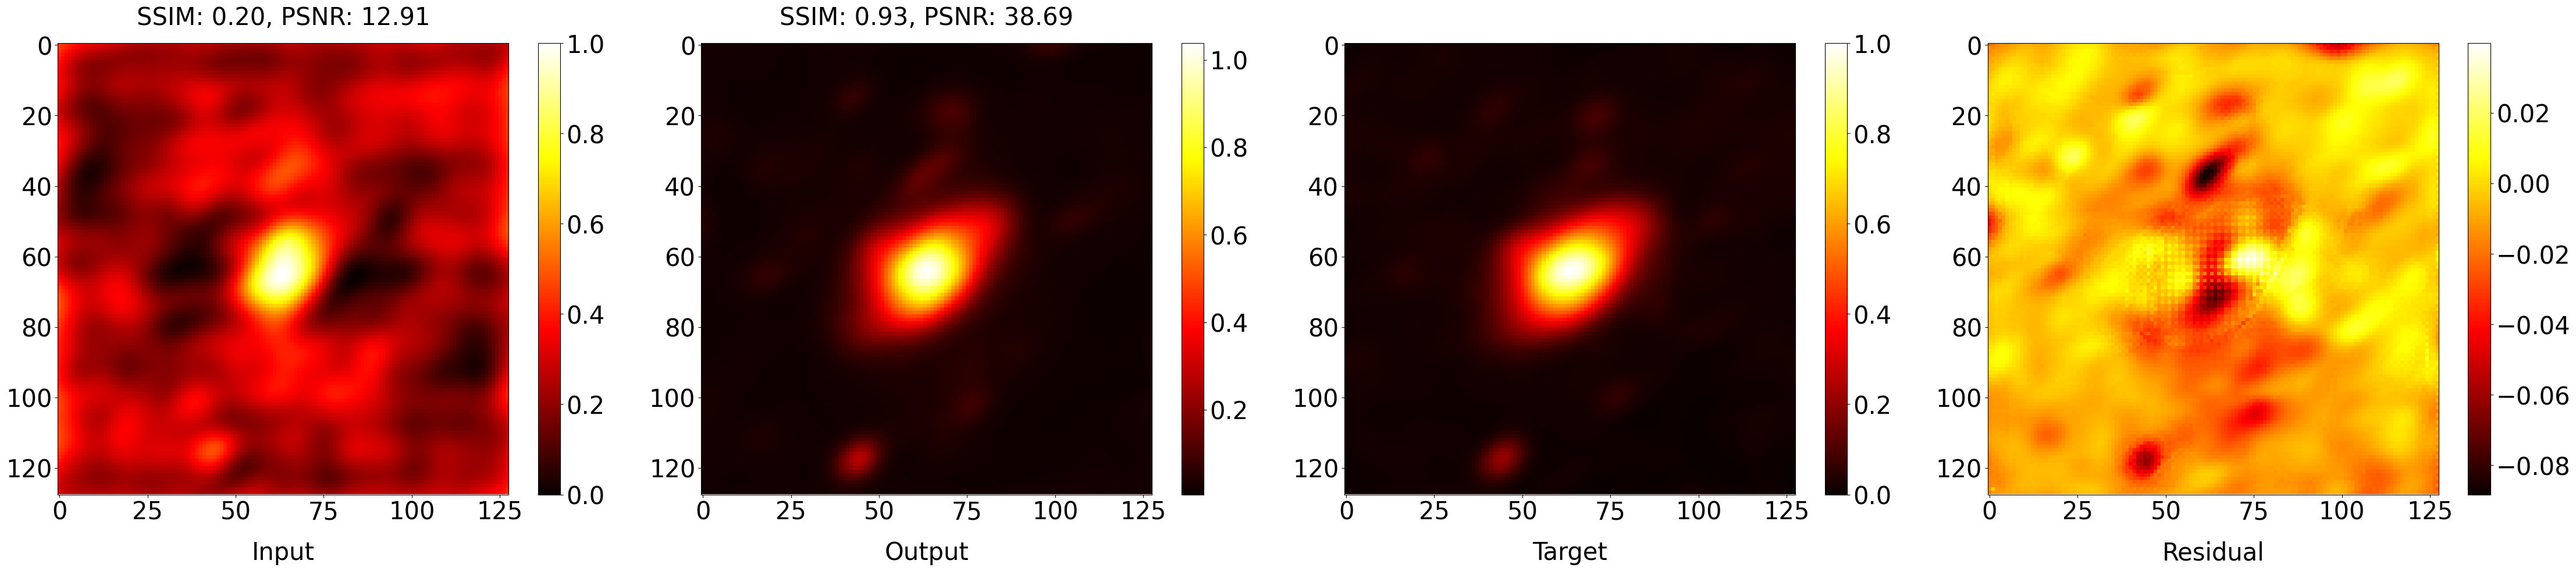

In [58]:
device = torch.device("cuda:1")
device
unet = UNet(1,1)
unet = unet.to(device)

state_dict = torch.load('experiment_lr=0.0005-epochs=120-shape=1.0-scale=0.1-ssim-0.01-l1-0.5.pt')

state_dict = remove_prefix(state_dict)
unet.load_state_dict(state_dict)
loss_func = nn.MSELoss()
num=1

img_dir = dataset[9409]['x']

img_true = dataset[9409]['y']
vic_recon = np.load(f'test1/none/slice_1/9409-recon_image.npy')[0]
vic_recon = minmax(vic_recon)

# 数据预处理
x = torch.Tensor(img_dir.reshape(1, 1, 128, 128).copy())
x = minmax(x)
x = x.to(device)
y = img_true
y = minmax(y)

# 模型推理
y_hat = unet(x)
# y_hat = minmax(y_hat.detach().cpu().numpy()[0, 0])  # 对 y_hat 进行归一化
y_hat = y_hat.detach().cpu().numpy()[0, 0]

# 计算 SSIM 和 PSNR
ssim_input = compute_ssim(y, x.detach().cpu().numpy()[0, 0])
psnr_input = compute_psnr(y, x.detach().cpu().numpy()[0, 0])

ssim_output = compute_ssim(y, y_hat)
psnr_output = compute_psnr(y, y_hat)

# 设置 Matplotlib 参数
from matplotlib import rcParams
rcParams['xtick.labelsize'] = 30
rcParams['ytick.labelsize'] = 30

# 绘制图像
plt.figure(figsize=(45, 9))

# Input 图像
plt.subplot(141)
plt.imshow(x.detach().cpu().numpy()[0, 0], cmap='hot')
plt.colorbar()
plt.title(f'SSIM: {ssim_input:.2f}, PSNR: {psnr_input:.2f}', fontsize=30, y=1.03)  # SSIM 和 PSNR 显示在上方
plt.xlabel('Input', fontsize=30, labelpad=20)  # 标签显示在下方

# Output 图像
plt.subplot(142)
plt.imshow(y_hat, cmap='hot')  # 使用归一化后的 y_hat
plt.colorbar()
plt.title(f'SSIM: {ssim_output:.2f}, PSNR: {psnr_output:.2f}', fontsize=30, y=1.03)  # SSIM 和 PSNR 显示在上方
plt.xlabel('Output', fontsize=30, labelpad=20)  # 标签显示在下方

# Target 图像
plt.subplot(143)
plt.imshow(y, cmap='hot')
plt.colorbar()
plt.xlabel('Target', fontsize=30, labelpad=20)  # 标签显示在下方

# Residual 图像
plt.subplot(144)
plt.imshow(y - y_hat, cmap='hot')  # 使用归一化后的 y_hat 计算残差
plt.colorbar()
plt.xlabel('Residual', fontsize=30, labelpad=20)  # 标签显示在下方

plt.tight_layout()
plt.show()
# plt.savefig('construction_comparation.pdf', dpi=400)

In [33]:
def normalize_psf(psf):
    """
    将PSF归一化为峰值等于1。
    参数：
        psf: 输入的二维PSF数组
    返回：
        psf_normalized: 归一化后的PSF数组
    """
    # 找到PSF的峰值
    peak_value = np.max(psf)
    # 如果峰值为0，避免除以0的错误
    if peak_value == 0:
        raise ValueError("PSF的峰值为0，无法归一化")
    # 将PSF归一化，使峰值等于1
    psf_normalized = psf / peak_value
    return psf_normalized

In [34]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import glob

In [35]:
psfImg = np.load('./data/psf.npy')
psfImg = normalize_psf(psfImg)


clean_beam, _  = fit_clean_beam(psfImg)
gain = 0.01
niter = 1500
fthresh = 0.0000010


def get_clean(dirtyImg):
    residImg, skyModel = hogbom(dirtyImg, psfImg, gain, niter, fthresh)
    restImg = restoreImg1(skyModel, residImg, clean_beam)
    return restImg


def get_our(dirtyImg):
    x = minmax(dirtyImg)
    x = torch.Tensor(x.reshape(1, 1, 128, 128).copy())
    x = x.to(device)
    with torch.no_grad():
        y_hat = unet(x)
    return y_hat.detach().cpu().numpy()[0,0]


def get_vic_by_dir_idx(dir_idx):
    dir_path = glob.glob(f'test1/none/slice_{dir_idx}/*recon_image.npy')
    vic_ddpm_recon = np.load(dir_path[0])
    return vic_ddpm_recon[0]


def get_dirty_by_dir_idx(dir_idx):
    dir_path = glob.glob(f'test1/none/slice_{dir_idx}/*dirty_image.npy')
    dirtyImg = np.load(dir_path[0])
    return dirtyImg


def get_target_by_dir_idx(dir_idx):
    idx = glob.glob(f'test1/none/slice_{dir_idx}/*dirty_image.npy')[0].split('/')[-1].split('-')[0]
    idx = int(idx)
    return dataset[idx]['y']

In [36]:
glob.glob('test1/none/slice_0/*dirty_image.npy')[0].split('/')[-1].split('-')[0]

'2466'

In [37]:

import os
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

# 你的现有参数
gain = 0.01
niter = 1500
fthresh = 0.000001



# Assuming these functions are defined: get_dirty, get_vic, get_clean, get_target, compute_ssim, get_our, compute_psnr

def process_directory(i):
    dirty = get_dirty_by_dir_idx(i)
    dirty = minmax(dirty)
    target = get_target_by_dir_idx(i)

    vic_recon = get_vic_by_dir_idx(i)
    clean_recon = get_clean(dirty)
    # our_recon = get_our(dirty)

    ssim_results = {
        'ssim_dirty_vs_target': compute_ssim(dirty, target),
        'ssim_vicddpm_vs_target': compute_ssim(vic_recon, target),
        'ssim_clean_vs_target': compute_ssim(clean_recon, target),
    }

    psnr_results = {
        'psnr_dirty_vs_target': compute_psnr(dirty, target),
        'psnr_vicddpm_vs_target': compute_psnr(vic_recon, target),
        'psnr_clean_vs_target': compute_psnr(clean_recon, target),
    }

    results = {**ssim_results, **psnr_results}
    return results

dirs = os.listdir('test1/none')
num_dirs = len(dirs)

ssim_dirty_vs_target = []
ssim_vicddpm_vs_target = []
ssim_clean_vs_target = []

psnr_dirty_vs_target = []
psnr_vicddpm_vs_target = []
psnr_clean_vs_target = []

psnr_ours_vs_target = []
ssim_ours_vs_target = []

# Use multiprocessing for dirty, vic, and clean reconstructions
with ProcessPoolExecutor() as executor:
    futures = {executor.submit(process_directory, i): i for i in range(num_dirs)}

    for future in tqdm(as_completed(futures), total=num_dirs):
        results = future.result()
        ssim_dirty_vs_target.append(results['ssim_dirty_vs_target'])
        ssim_vicddpm_vs_target.append(results['ssim_vicddpm_vs_target'])
        ssim_clean_vs_target.append(results['ssim_clean_vs_target'])

        psnr_dirty_vs_target.append(results['psnr_dirty_vs_target'])
        psnr_vicddpm_vs_target.append(results['psnr_vicddpm_vs_target'])
        psnr_clean_vs_target.append(results['psnr_clean_vs_target'])

# Now compute ssim and psnr for our_recon in a separate loop
for i in tqdm(range(num_dirs)):
    dirty = get_dirty_by_dir_idx(i)
    our_recon = get_our(dirty)
    target = get_target_by_dir_idx(i)
    ssim_ours_vs_target.append(compute_ssim(our_recon, target))
    psnr_ours_vs_target.append(compute_psnr(our_recon, target))

100%|██████████| 512/512 [00:09<00:00, 51.69it/s]


In [38]:
ssim_data = {'dirty': ssim_dirty_vs_target,
        'vicddpm': ssim_vicddpm_vs_target,
        'ours': ssim_ours_vs_target,
        'clean': ssim_clean_vs_target}
ssim_df = pd.DataFrame(data=ssim_data)
ssim_df.describe()

psnr_data = {'dirty': psnr_dirty_vs_target,
        'vicddpm': psnr_vicddpm_vs_target,
        'ours': psnr_ours_vs_target,
        'clean': psnr_clean_vs_target}
psnr_df = pd.DataFrame(data=psnr_data)
psnr_df.describe()


,dirty,vicddpm,ours,clean
count,512.000000,512.000000,512.000000,512.000000
mean,11.855139,27.512979,35.468091,15.242640
std,1.326361,2.243011,3.468420,1.869418
min,7.861577,17.156781,20.427550,10.548328
25%,10.992350,26.380713,33.529199,13.927256
50%,11.920144,27.729226,36.120029,15.250461
75%,12.759408,29.024029,37.924356,16.564315
max,14.944517,32.059566,42.499945,19.986627


In [39]:
ssim_df.describe()

,dirty,vicddpm,ours,clean
count,512.000000,512.000000,512.000000,512.000000
mean,0.216758,0.751526,0.908019,0.303944
std,0.058988,0.101909,0.043893,0.078324
min,0.109408,0.318309,0.663351,0.143418
25%,0.179521,0.716103,0.892831,0.247947
50%,0.203629,0.780211,0.918693,0.297795
75%,0.242108,0.821262,0.936649,0.341023
max,0.516092,0.892822,0.964366,0.694012


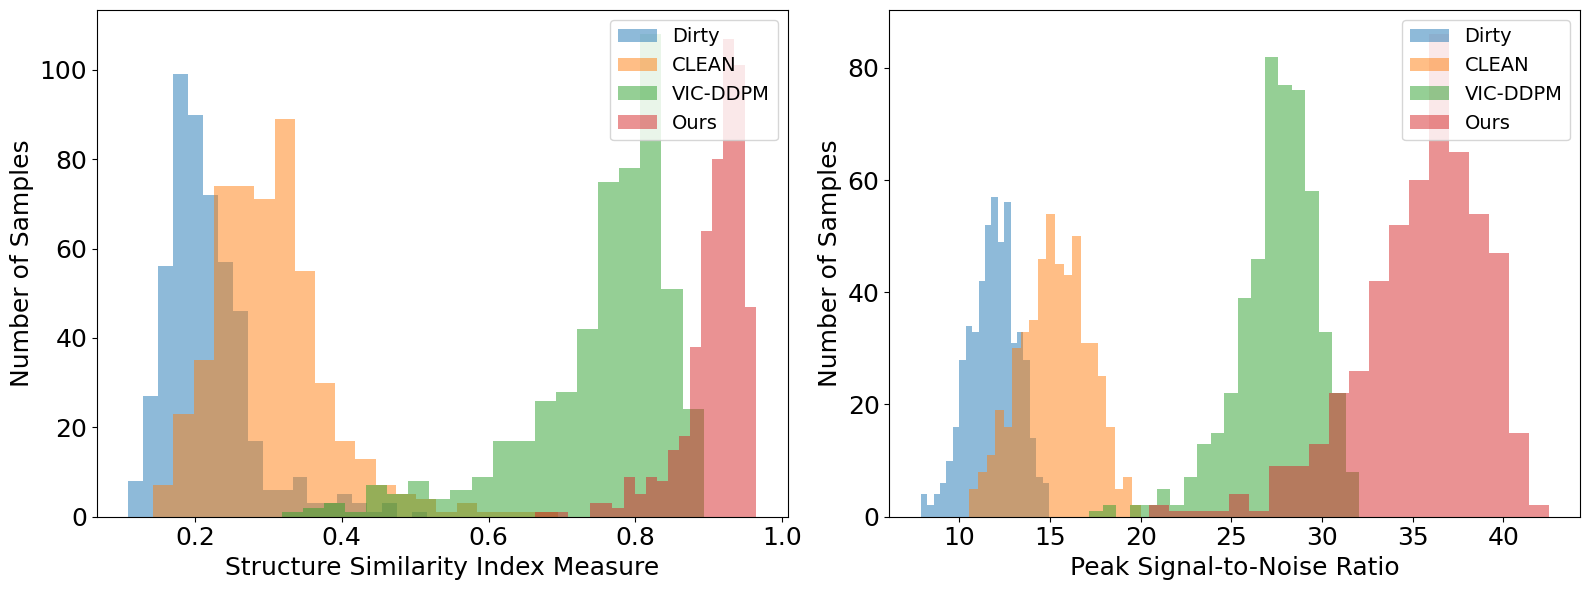

In [40]:
import matplotlib.pyplot as plt

# 创建一个包含两个子图的图形
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# 第一个子图：SSIM Histogram
axs[0].hist(ssim_dirty_vs_target, bins=20, alpha=0.5, label='Dirty')
axs[0].hist(ssim_clean_vs_target, bins=20, alpha=0.5, label='CLEAN')
axs[0].hist(ssim_vicddpm_vs_target, bins=20, alpha=0.5, label='VIC-DDPM')
axs[0].hist(ssim_ours_vs_target, bins=20, alpha=0.5, label='Ours')
axs[0].legend(loc='upper right', fontsize=14)

# 设置坐标轴的字体大小
axs[0].tick_params(axis='both', labelsize=18)
axs[0].set_xlabel('Structure Similarity Index Measure', fontsize=18)
axs[0].set_ylabel('Number of Samples', fontsize=18)

# 第二个子图：PSNR Histogram
axs[1].hist(psnr_dirty_vs_target, bins=20, alpha=0.5, label='Dirty')
axs[1].hist(psnr_clean_vs_target, bins=20, alpha=0.5, label='CLEAN')
axs[1].hist(psnr_vicddpm_vs_target, bins=20, alpha=0.5, label='VIC-DDPM')
axs[1].hist(psnr_ours_vs_target, bins=20, alpha=0.5, label='Ours')
axs[1].legend(loc='upper right', fontsize=14)

# 设置坐标轴的字体大小
axs[1].tick_params(axis='both', labelsize=18)
axs[1].set_xlabel('Peak Signal-to-Noise Ratio', fontsize=18)
axs[1].set_ylabel('Number of Samples', fontsize=18)

# 显示图形
plt.tight_layout()
plt.show()

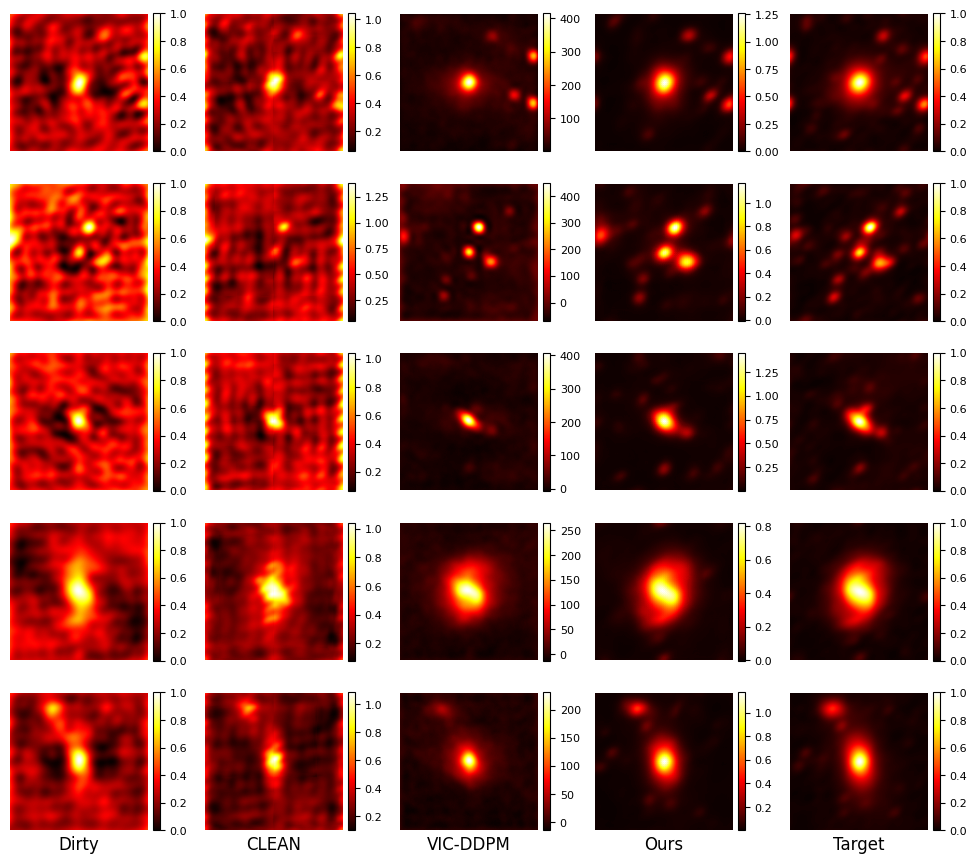

In [41]:
nSamples = 5 # 随机抽样的个数
nCols = 5      # 每行显示的列数
nRows = (nSamples + nCols - 1) // nCols  # 根据样本个数计算行数
nRows = nSamples

cmap = 'hot'
plt.figure(figsize=(12, nRows * 2.2))  # 动态调整图形大小
# 你的现有参数
gain = 0.01
niter = 1500
fthresh = 0.0000010

for i in range(5):
    idx = random.randint(0, 512)
    dirty = get_dirty_by_dir_idx(idx)
    dirty = minmax(dirty)
    our_recon = get_our(dirty)
    vic_recon = get_vic_by_dir_idx(idx)
    clean_recon = get_clean(dirty)
    target = get_target_by_dir_idx(idx)
    
    # 显示脏图像
    plt.subplot(nRows, nCols, i * nCols + 1)
    im = plt.imshow(dirty, cmap=cmap)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)  # 设置颜色条刻度的字体大小
    if i == nSamples - 1:
        plt.title('Dirty', y=-0.2)
    plt.axis('off')

    # 显示清理图像
    plt.subplot(nRows, nCols, i * nCols + 2)
    im = plt.imshow(clean_recon, cmap=cmap)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)  # 设置颜色条刻度的字体大小
    if i == nSamples - 1:
        plt.title('CLEAN', y=-0.2)
    plt.axis('off')

    # 显示 VIC-DDPM 重建图像
    plt.subplot(nRows, nCols, i * nCols + 3)
    im = plt.imshow(vic_recon, cmap=cmap)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)  # 设置颜色条刻度的字体大小
    if i == nSamples - 1:
        plt.title('VIC-DDPM', y=-0.2)
    plt.axis('off')

    # 显示我们的模型重建图像
    plt.subplot(nRows, nCols, i * nCols + 4)
    im = plt.imshow(our_recon, cmap=cmap)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)  # 设置颜色条刻度的字体大小
    if i == nSamples - 1:
        plt.title('Ours', y=-0.2)
    plt.axis('off')

    # 显示target图像
    plt.subplot(nRows, nCols, i * nCols + 5)
    im = plt.imshow(target, cmap=cmap)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)  # 设置颜色条刻度的字体大小
    if i == nSamples - 1:
        plt.title('Target', y=-0.2)
    plt.axis('off')

# 调整子图之间的间隔，这里通过 wspace 参数增加列与列之间的间隔
plt.subplots_adjust(wspace=0.3, hspace=0.01)

plt.show()

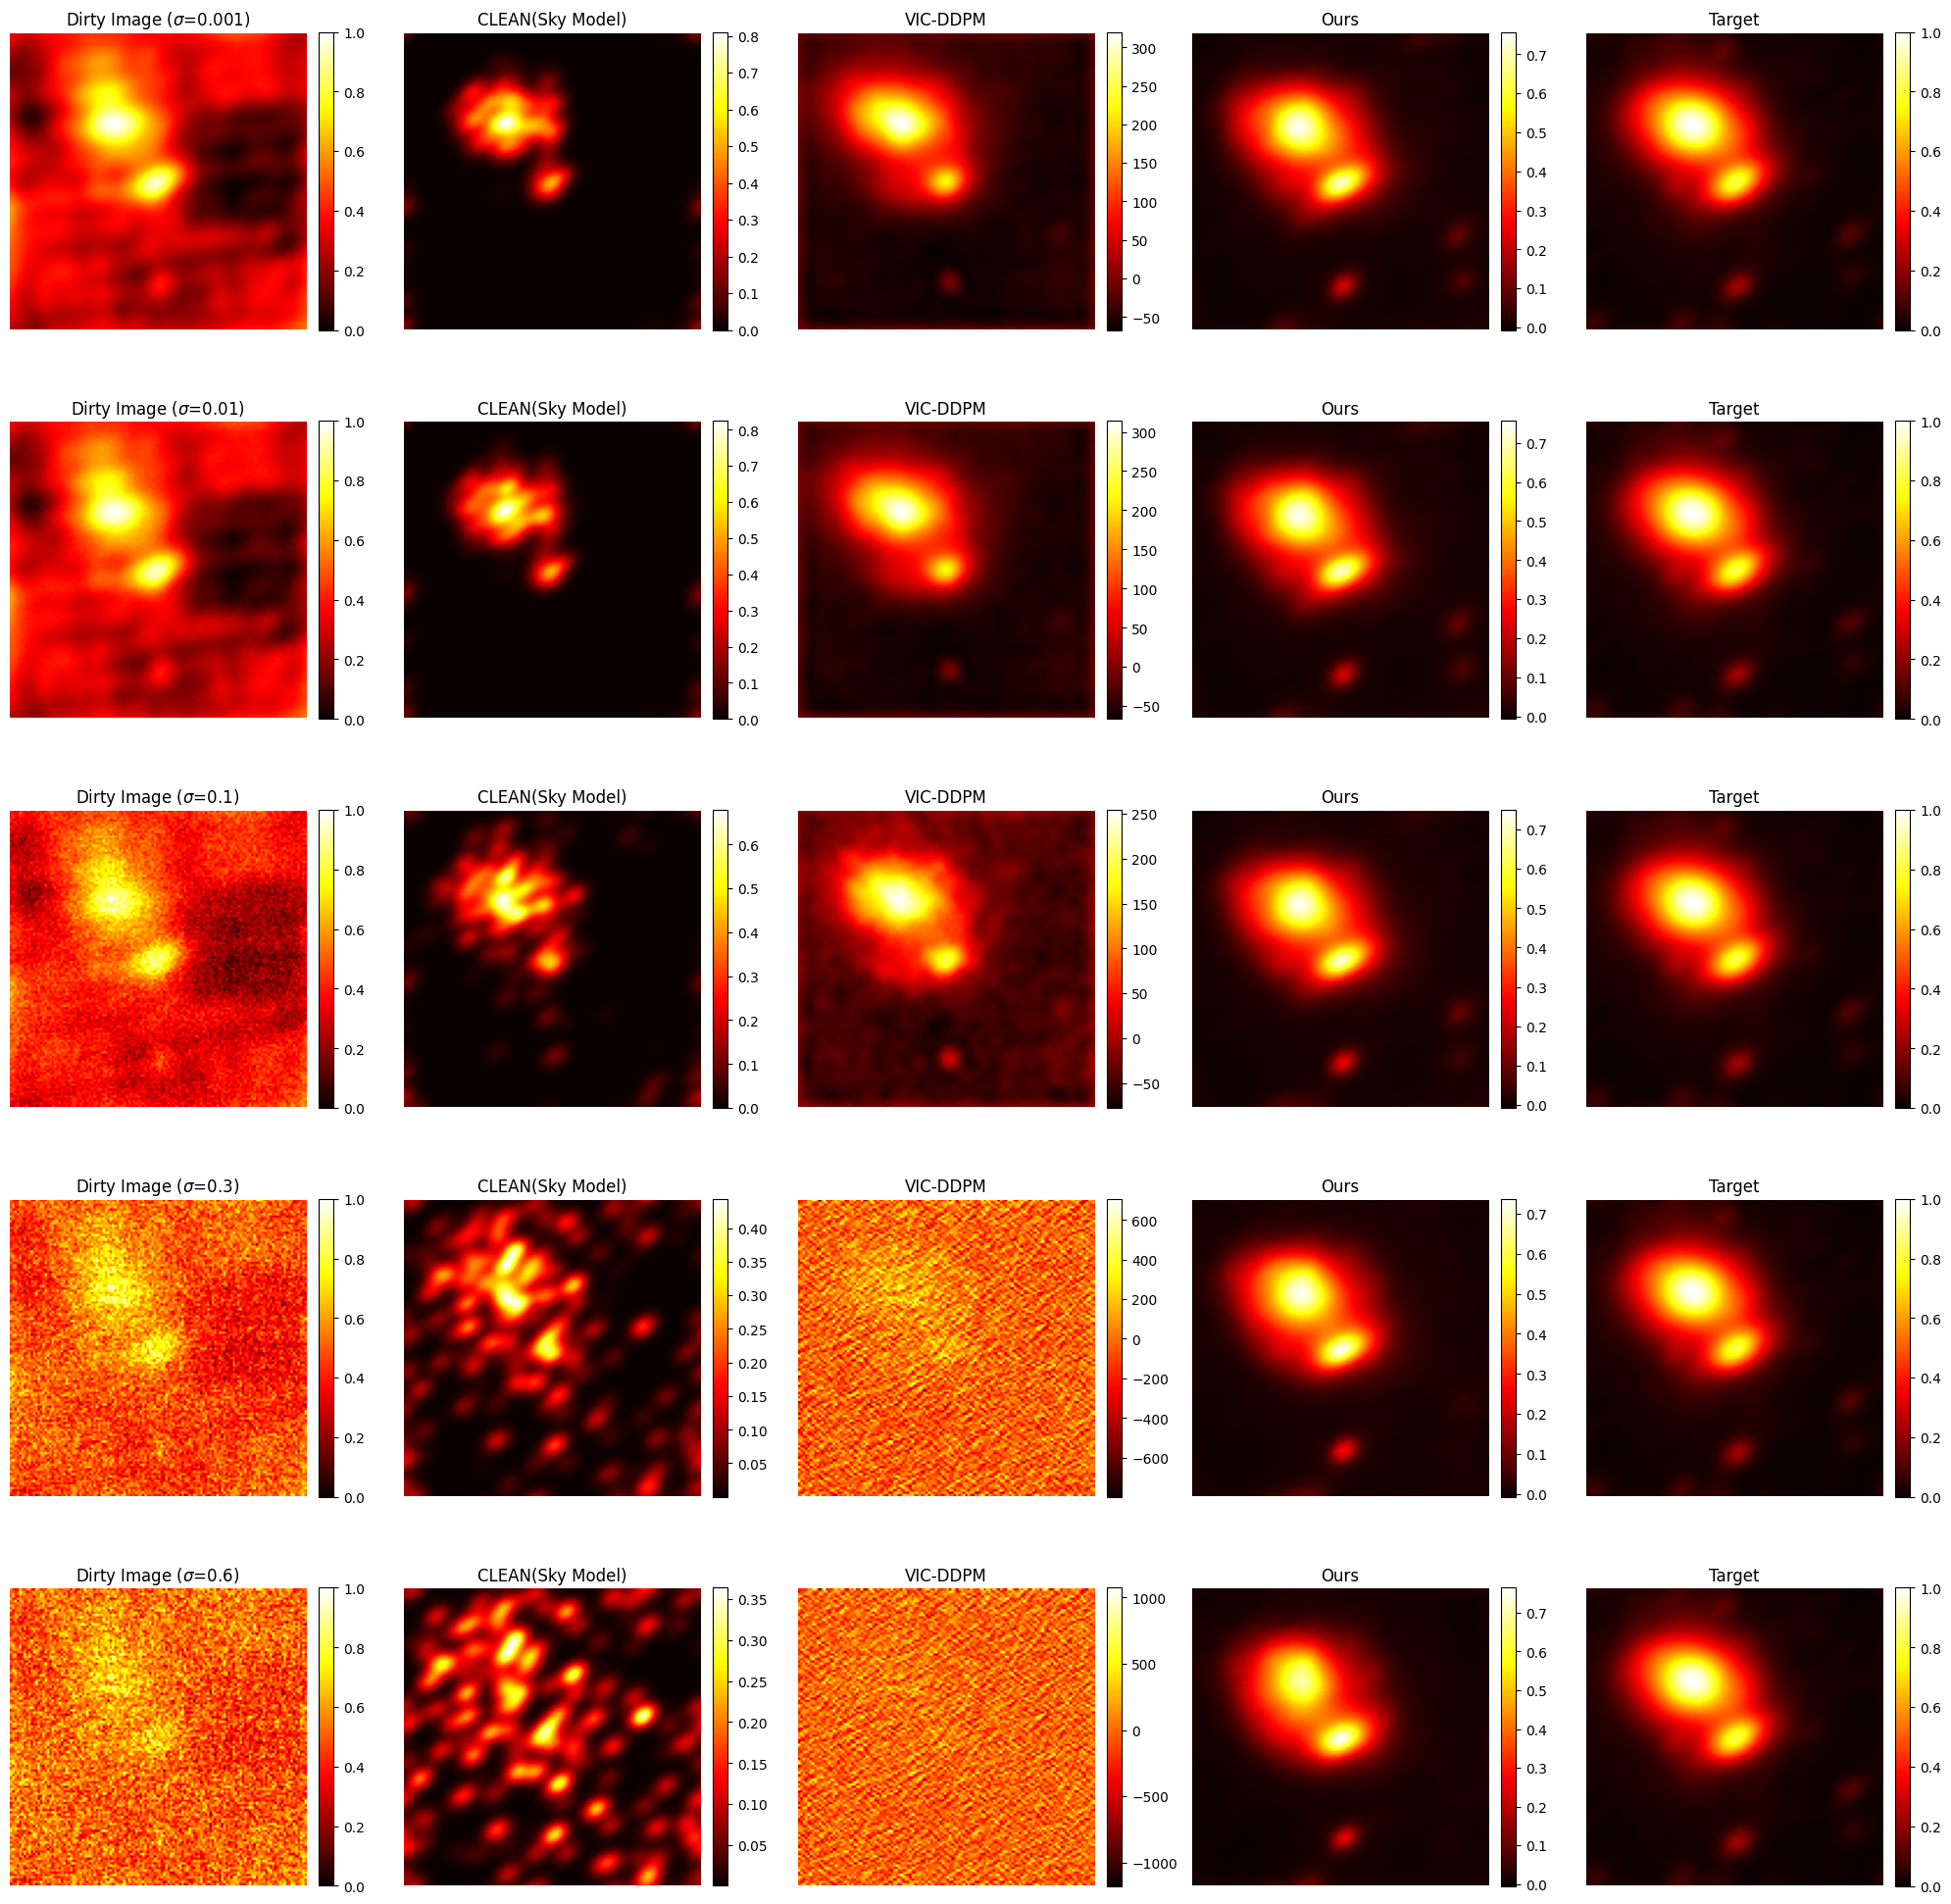

In [42]:
# 定义噪声水平
noise_levels = [0.001, 0.01, 0.1, 0.3, 0.6]  # 示例噪声水平
sample_idx = 2450  # 固定的样本索引

gain = 0.01
niter = 1500
fthresh = 0.000001

# 创建五行五列的子图布局
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))  # 调整整个图形的大小

# 遍历每个噪声水平
for row, noise_level in enumerate(noise_levels):
    # 加载 dirty image
    img_dir = np.load(f'test_noise_level_{noise_level}/none/slice_2/{sample_idx}-dirty_image.npy')
    img_dir = minmax(img_dir)  # 假设 minmax 是归一化函数
    
    # 执行 CLEAN 算法
    residImg, skyModel = hogbom(img_dir, psfImg, gain, niter, fthresh)
    clean = restoreImg1(skyModel, residImg, clean_beam, False)
    
    # 加载其他重建结果
    vic_recon = np.load(f'test_noise_level_{noise_level}/none/slice_2/{sample_idx}-recon_image.npy')[0]
    our_recon = get_our(img_dir)  # 假设 get_our 是获取我们方法的结果的函数
    target = dataset[sample_idx]['y']
    
    # 绘制子图并添加 colorbar
    images = [img_dir, clean, vic_recon, our_recon, target]
    titles = [f'Dirty Image ($\sigma$={noise_level})', 'CLEAN(Sky Model)', 'VIC-DDPM', 'Ours', 'Target']
    
    for col, (img, title) in enumerate(zip(images, titles)):
        im = axs[row, col].imshow(img, cmap='hot')
        axs[row, col].set_title(title)
        axs[row, col].axis('off')
        # fig.colorbar(im, ax=axs[row, col], orientation='vertical')  # 添加 colorbar
        
        # 添加 colorbar，调整参数以使 colorbar 和图片一样高
        cbar = fig.colorbar(im, ax=axs[row, col], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=10)  # 设置 colorbar 标签的字体大小

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

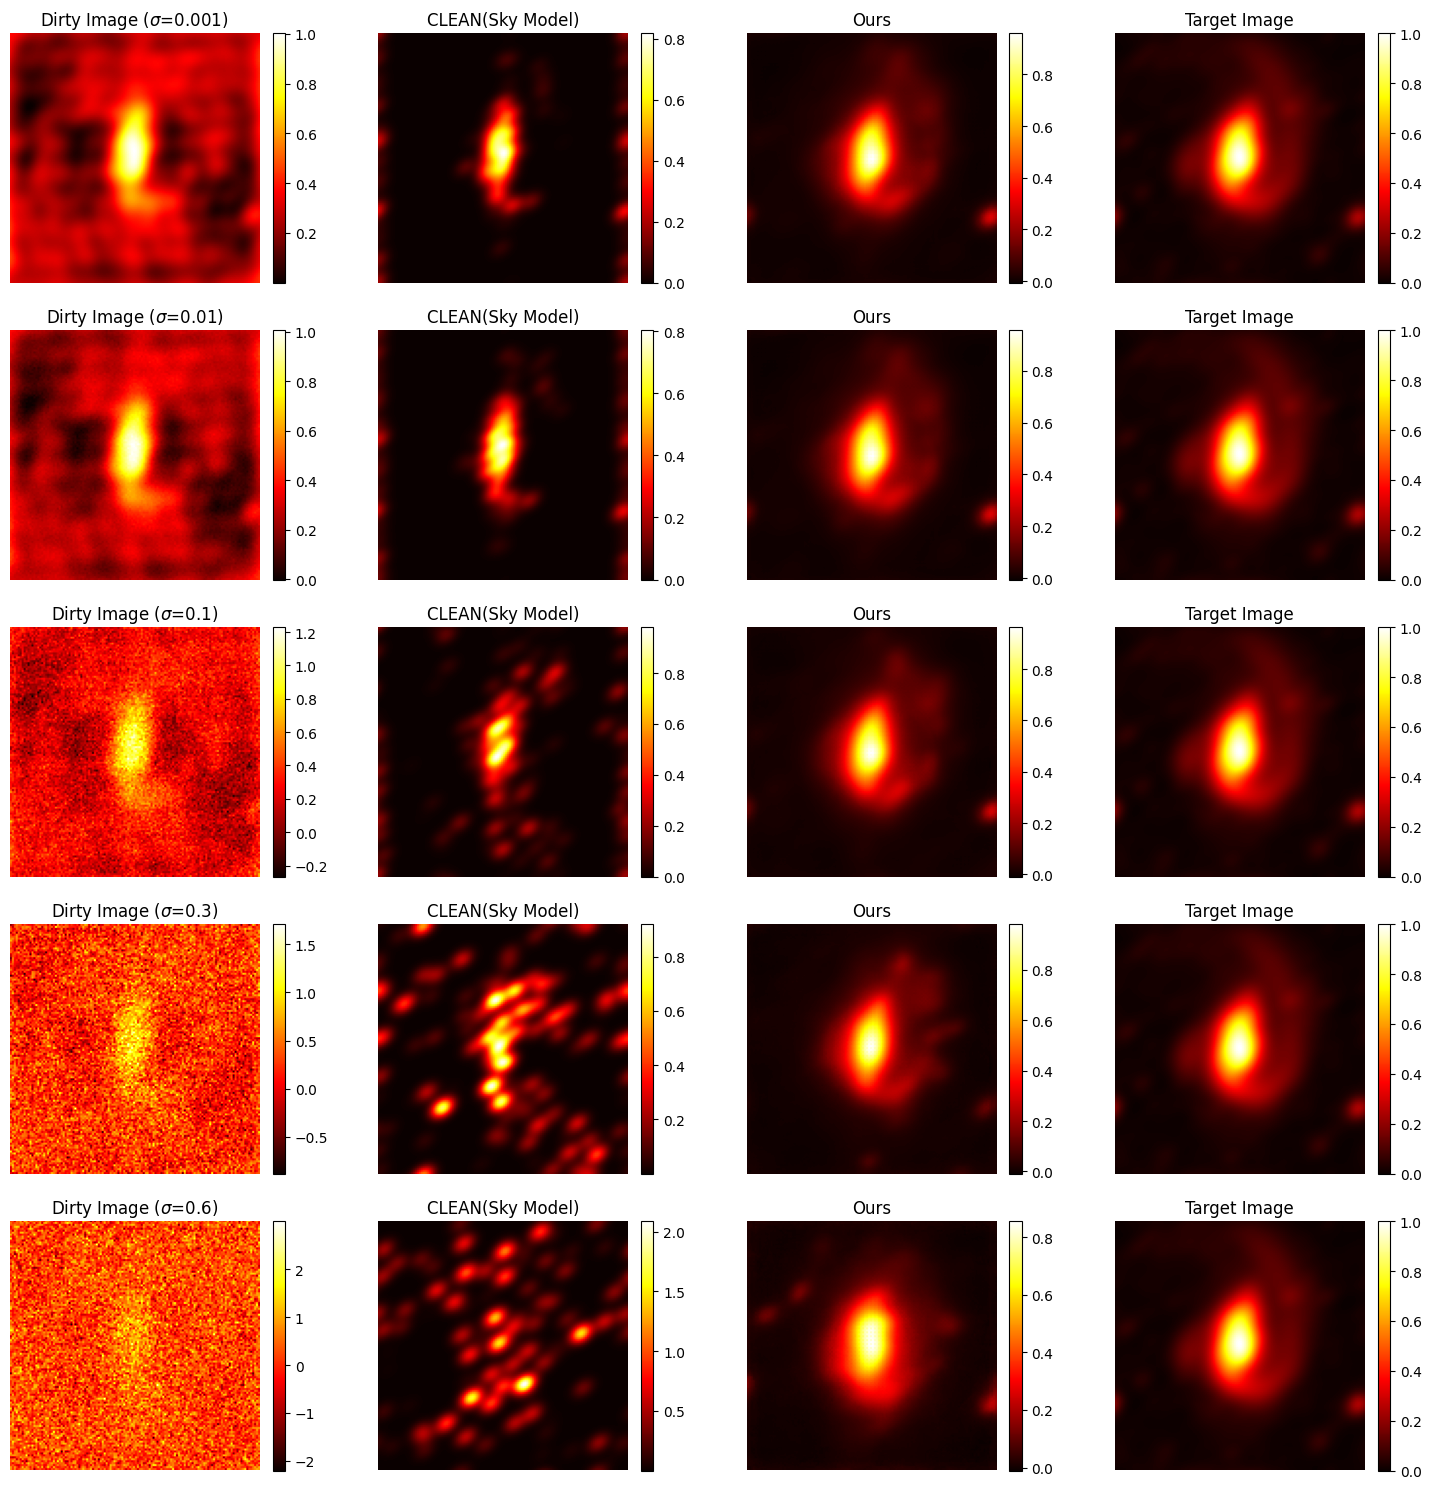

In [43]:
# 你的现有参数
gain = 0.01
niter = 1500
fthresh = 0.0000010
fig, axs = plt.subplots(5, 4, figsize=(15, 15))  # figsize可以根据需要

noise_level = [0.001, 0.01, 0.1, 0.3, 0.6]

idx = random.randint(0, 512)
# idx = 324
# idx = -1
idx = 405
cmap = 'hot'
for i in range(5):
    # 加载图像数据
    img_dir = dataset[idx]['x']
    img_dir = img_dir + np.random.normal(0, noise_level[i], img_dir.shape)
    # img_true = np.load(f'./none1/slice_{idx}/image.npy')
    img_true = dataset[idx]['y']

    # 假设to_model是一个函数，它接受img_dir作为输入并返回重建的图像
    # img_dir = minmax(img_dir)
    # ours_recon = to_model(img_dir)
    ours_recon = get_our(img_dir)
    residImg, skyModel = hogbom(img_dir, psfImg, gain, niter, fthresh)
    # idealPSFparams = idealPSF(psfImg)  # 计算理想 PSF 参数
    clean = restoreImg1(skyModel, residImg, clean_beam, False)
    # clean = get_clean(img_dir)

    im0 = axs[i, 0].imshow(img_dir, cmap=cmap)
    axs[i, 0].imshow(img_dir, cmap=cmap)
    axs[i, 0].axis('off')  # 关闭坐标轴
    axs[i, 0].set_title('Dirty Image ($\sigma$=' + str(noise_level[i]) + ')')
    cbar0 = fig.colorbar(im0, ax=axs[i, 0], fraction=0.046, pad=0.04)  # 调整颜色条大小和间距
    cbar0.ax.tick_params(labelsize=10)  # 设置颜色条标签的字体大小为8

    im1 = axs[i, 1].imshow(clean, cmap=cmap)
    axs[i, 1].imshow(clean, cmap=cmap)
    axs[i, 1].axis('off')  # 关闭坐标轴
    axs[i, 1].set_title('CLEAN(Sky Model)')
    cbar1 = fig.colorbar(im1, ax=axs[i, 1], fraction=0.046, pad=0.04)  # 调整颜色条大小和间距
    cbar1.ax.tick_params(labelsize=10)  # 设置颜色条标签的字体大小为8

    im2 = axs[i, 2].imshow(ours_recon, cmap=cmap)
    axs[i, 2].imshow(ours_recon, cmap=cmap)
    axs[i, 2].axis('off')  # 关闭坐标轴
    axs[i, 2].set_title('Ours')
    cbar2 = fig.colorbar(im2, ax=axs[i, 2], fraction=0.046, pad=0.04)  # 调整颜色条大小和间距
    cbar2.ax.tick_params(labelsize=10)  # 设置颜色条标签的字体大小为8

    im3 = axs[i, 3].imshow(img_true, cmap=cmap)
    axs[i, 3].imshow(img_true, cmap=cmap)
    axs[i, 3].axis('off')  # 关闭坐标轴
    axs[i, 3].set_title('Target Image')
    cbar3 = fig.colorbar(im3, ax=axs[i, 3], fraction=0.046, pad=0.04)  # 调整颜色条大小和间距
    cbar3.ax.tick_params(labelsize=10)  # 设置颜色条标签的字体大小为8

# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()

In [52]:
gain = 0.01
niter = 1500
fthresh = 0.0000010
a = time.time()
for i in range(100):
    dirty = dataset[i]['x']
    clean_recon = get_clean(dirty)
b = time.time()
print(f"平均时间：{(b-a)/100} 秒")

平均时间：0.1476974081993103 秒


In [53]:
a = time.time()
for i in range(100):
    dirty = dataset[i]['x']
    our_recon = get_our(dirty)
b = time.time()
print(f"平均时间：{(b-a)/100} 秒")

平均时间：0.010495386123657226 秒
